In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
# Setup output and imports
from tslib import ts_import, ts_output, ts_log, ts_csvout
PROG = "pplate-defl-paramspace"   # This experiment's ID
OUT_D = ts_output(PROG)           # Output file directory

# import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

from scipy.optimize import root_scalar

libem = ts_import("libem", "20211006")
cmp = ts_import("components", "20211006")
rlm = ts_import("realmodel", "20211004")
libvis = ts_import("libvis", "20211018")

Results directory already exists: results\pplate-defl-paramspace20211020


## Set up dimensions and conversions

In [47]:
conv = rlm.Conversion(
    mass=1, # kg (1amu) / sim unit
    length=1, #1cm / sim unit
    time=1,
    charge=1,
    voltage=1
)

# Goal for deflection voltage is 10V for 200eV ions

DFDIM = {
    "length": conv.real_to_sim(3, "length"), # ideal is 3cm
    "box": conv.real_to_sim(2, "length"),
    "diam": conv.real_to_sim(1, "length"),
    "boxwall": conv.real_to_sim(0.2, "length"),

    "panel_l": conv.real_to_sim(2.3, "length"),
    "panel_w": conv.real_to_sim(1.6, "length"),
    "panel_h": conv.real_to_sim(0.2, "length"),
    "panel_gap": conv.real_to_sim(0.6, "length")
}

SPACE_SIZE = [round(DFDIM["length"] * 1.5), round(DFDIM["box"] * 1.5), round(DFDIM["box"] * 1.5)]
SPACE_TLFT = [-(s / 2.0) for s in SPACE_SIZE]

SCALE = 20

ts_log(PROG, "SIMULATION SPACE SIZE:", ", ".join([str(s) for s in SPACE_SIZE]))
ts_log(PROG, "SIMULATION SPACE TOP_LEFT:", ", ".join([str(tl) for tl in SPACE_TLFT]))
ts_log(PROG, "SIMULATION SCALE SET AT:", SCALE)


SIMULATION SPACE SIZE: 4, 3, 3
SIMULATION SPACE TOP_LEFT: -2.0, -1.5, -1.5
SIMULATION SCALE SET AT: 20


## Gate generator

In [9]:
def generate_dfgate(panel_pos, panel_dim, body_V, hole_V, electrode_V):
    # Create simulation space from global parameters
    sim = libem.EMSimulationSpace3D(space_size=SPACE_SIZE, top_left=SPACE_TLFT, scale=SCALE)

    # CREATE GATE COMPONENTS
    # Body - Hollow Rectangular Prism
    body = (
        (-(DFDIM["length"] / 2.0), -(DFDIM["box"] / 2.0), -(DFDIM["box"] / 2.0)),
        (DFDIM["length"], DFDIM["box"], DFDIM["box"]),
        DFDIM["boxwall"],
        body_V
    )
    # End Holes - Closed Cylinders
    ehole_0_mask = cmp.EMObjectMasks.closed_cylinder_in_plane(
        sim,
        (-(DFDIM["length"] / 2.0), 0, 0),
        DFDIM["diam"] / 2.0,
        DFDIM["boxwall"],
        0
    )
    ehole_1_mask = cmp.EMObjectMasks.closed_cylinder_in_plane(
        sim,
        ((DFDIM["length"] / 2.0), 0, 0),
        DFDIM["diam"] / 2.0,
        DFDIM["boxwall"],
        0,
        direction=-1
    )
    # Deflection Panel - Rectangular Prism
    top_panel = (
        (*panel_pos[:2], panel_pos[3]),
        panel_dim,
        -electrode_V
    )
    bottom_panel = (
        (*panel_pos[:2], panel_pos[2]),
        panel_dim,
        electrode_V
    )

    # Generate boundary enforcer
    enf = [
        cmp.enf(+1, cmp.EMObjects.rectangular_prism_hollow, *body),
        cmp.enf(-1, cmp.EMObjects.arbitrary_mask, ehole_0_mask, hole_V),
        cmp.enf(-1, cmp.EMObjects.arbitrary_mask, ehole_1_mask, hole_V),
        cmp.enf(+1, cmp.EMObjects.rectangular_prism_solid, *top_panel),
        cmp.enf(+1, cmp.EMObjects.rectangular_prism_solid, *bottom_panel)
    ]

    return sim, enf


## Visualize Particle Path

Visualizing the deflection gate with particle path.
 - Computing electric field
 - Computing particle motion
 - Rendering 2D Electric Field Cross-Sections at 0 with Motion
Particle path experiment ran.


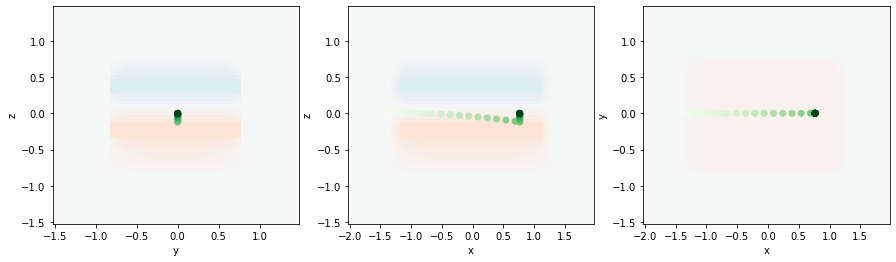

In [51]:
PARTICLE_OPTS = {
    "mass": (conv.real_to_sim(1, "mass"), 0),
    "charge": (conv.real_to_sim(1, "charge"), 0),
    "initial_loc": ((conv.real_to_sim(-1.4, "length"), 0, 0), (0, 0, 0)),
    "initial_v": ((conv.real_to_sim(1, "length / time"), 0, 0), (0, 0, 0)),
    "bounce_coef": 1
}

def visualize_dfgate_particle(particle_opts, panel_pos, body_V, hole_V, electrode_V):
    V_norm = max(abs(electrode_V), abs(hole_V), abs(body_V), 0.1)

    print("Visualizing the deflection gate with particle path.")
    sim, enf = generate_dfgate(
        panel_pos,
        (DFDIM["panel_l"], DFDIM["panel_w"], DFDIM["panel_h"]),
        body_V, hole_V, electrode_V)
    print(" - Computing electric field")
    sim.compute(enf)
    sim.get_efield()
    print(" - Computing particle motion")
    particle = libem.ChargedParticle3D(sim, particle_opts["mass"][0], particle_opts["charge"][0],
                                       (particle_opts["initial_loc"][0][0], 0, 0),
                                       particle_opts["initial_v"][0], bounce=particle_opts["bounce_coef"])
    particle.compute_motion((0, (DFDIM["length"] * 1.5) / particle_opts["initial_v"][0][0]))
    print(" - Rendering 2D Electric Field Cross-Sections at 0 with Motion")


    
    _, axs = plt.subplots(1, 3, figsize=(15, 4))
    labels = ["x", "y", "z"]
    for i, ax in enumerate(axs):
        sub_label = labels[:]
        sub_label.pop(i)
        ax.set_xlabel(sub_label[0])
        ax.set_ylabel(sub_label[1])

        sim2d = libem.EMSimulationSpace2D.from_3d(sim, axis=i, location=0)
        libvis.Visualizations.colormesh_2d(sim2d, color_norm=V_norm, graph_ax=ax)
        libvis.Visualizations.trajectory_2d(particle.time, particle.position, axis=i, graph_ax=ax)

    # Save the simulation results
    # Columns: MASS, CHARGE, X_0, Vx_0, Vy_0, Vz_0, BOUNCE, X_1, Y_1, Z_1
    ts_csvout(PROG, "particle_paths.csv",
        [particle_opts["mass"][0], particle_opts["charge"][0], particle_opts["initial_loc"][0][0], *particle_opts["initial_v"][0],
        particle_opts["bounce_coef"], *particle.position.T[-1]]
    )
    # Save image
    plt.savefig(OUT_D + "/ppath.png")
    # Log
    ts_log(PROG, "Particle path experiment ran.")


visualize_dfgate_particle(
    PARTICLE_OPTS,
    (-(DFDIM["panel_l"] / 2.0), -(DFDIM["panel_w"] / 2.0), -DFDIM["panel_gap"] / 2.0, DFDIM["panel_gap"] / 2.0),
    0, 0, -0.014
)


L = 0.1 ; G = 0.4
   0 -> 1.6
   1.0 -> -44.22
   0.035 -> 1.6
   0.304 -> -1.12
   0.17 -> -0.99
   0.102 -> 1.55
   0.136 -> -0.6
=> Minimum V: 0.119
L = 0.1 ; G = 0.6
   0 -> 1.6
   1.0 -> -1.84
   0.465 -> -1.13
   0.229 -> -0.52
   0.117 -> 1.57
   0.209 -> -0.44
   0.169 -> 1.55
=> Minimum V: 0.189
L = 0.1 ; G = 0.8
   0 -> 1.6
   1.0 -> -1.2
   0.571 -> -1.15
   0.252 -> 1.55
   0.411 -> -0.57
   0.355 -> -0.43
   0.31 -> 1.53
=> Minimum V: 0.333
L = 0.1 ; G = 1.0
   0 -> 1.6
   1.0 -> -1.15
   0.583 -> -0.45
   0.416 -> 1.55
   0.508 -> 1.53
   0.57 -> -0.43
   0.543 -> 1.51
=> Minimum V: 0.556
L = 0.3 ; G = 0.4
   0 -> 1.6
   1.0 -> -3.72
   0.301 -> -1.84
   0.123 -> -1.14
   0.062 -> -0.43
   0.057 -> 1.52
   0.059 -> -0.43
=> Minimum V: 0.058
L = 0.3 ; G = 0.6
   0 -> 1.6
   1.0 -> -0.36
   0.816 -> -2.26
   0.103 -> -0.43
   0.059 -> 1.58
=> Minimum V: 0.081
L = 0.3 ; G = 0.8
   0 -> 1.6
   1.0 -> -1.9
   0.457 -> -1.12
   0.228 -> -0.76
   0.114 -> 1.56
   0.201 -> -0.57


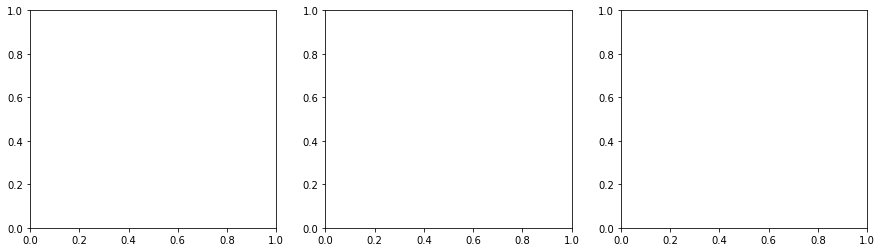

In [34]:
def generate_minV_space(particle_opts, panel_l=(0.1, 2.8, 0.1), panel_g=(1, 1.5, 0.1), visualize=False):
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    video = libvis.VideoMaker(fig, axs)

    qKe = particle_opts["charge"][0] * (particle_opts["mass"][0] / 2.0) * (particle_opts["initial_v"][0][0]**2)

    ts_csvout(
        PROG,
        "minv_grid.csv",
        ["PARTICLE_QKE", "PLATE_L", "PLATE_GAP", "PLATE_MINV"],
        append=False
    )

    def voltage_fn(V, l, g):
        # Returns a negative value if stopped "too soon", or a positive one if the particle escapes.
        sim, enf = generate_dfgate(
            (-(DFDIM["length"] / 2.0) + DFDIM["boxwall"], -(DFDIM["box"] / 2.0) + DFDIM["boxwall"], -(g / 2.0), g / 2.0),
            (l, DFDIM["panel_w"] - (2 * DFDIM["boxwall"]), DFDIM["panel_h"]),
            0, 0, V)

        sim.compute(enf)
        sim.get_efield()

        particle = libem.ChargedParticle3D(sim, particle_opts["mass"][0], particle_opts["charge"][0],
                                        (particle_opts["initial_loc"][0][0], 0, 0),
                                        particle_opts["initial_v"][0], bounce=particle_opts["bounce_coef"])
        particle.compute_motion((0, (DFDIM["length"] * 1.5) / particle_opts["initial_v"][0][0]))

        if visualize:
            video.new_frame()

            labels = ["x", "y", "z"]
            for i, ax in enumerate(axs):
                sub_label = labels[:]
                sub_label.pop(i)
                ax.set_xlabel(sub_label[0])
                ax.set_ylabel(sub_label[1])

                sim2d = libem.EMSimulationSpace2D.from_3d(sim, axis=i, location=0)
                libvis.Visualizations.colormesh_2d(sim2d, color_norm=qKe, graph_ax=ax)
                libvis.Visualizations.trajectory_2d(particle.time, particle.position, axis=i, graph_ax=ax)

            video.draw_frame()

        metric = 0
        if particle.position[0,-1] > DFDIM["length"] / 2.0:
            metric = particle.position[0,-1] - (DFDIM["length"] / 2.0)
        else:
            metric = -1 * (np.max(particle.position[1]**2) + np.max(particle.position[2]**2)) * particle.num_bounces

        print("  ", round(V, 3), "->", round(metric, 2))
        return metric

    l_domain = np.arange(*panel_l)
    g_domain = np.arange(*panel_g)
    minv_grid = np.zeros((l_domain.shape[0], g_domain.shape[0]), dtype=float)
    for i, l in enumerate(l_domain):
        for j, g in enumerate(g_domain):
            print("L =", round(l, 3), "; G =", round(g, 3))
            min_v = root_scalar(
                voltage_fn,
                args=(l, g),
                method="toms748",
                bracket=(0, 2 * qKe),
                xtol=qKe / 10.0,
                x0=qKe / 2.0
            )
            ts_csvout(PROG, 
                "minv_grid.csv",
                [qKe, l, g, min_v.root],
                append=True
            )
            minv_grid[i,j] = min_v.root
            print("=> Minimum V:", round(min_v.root, 3))

    if visualize: video.make_movie(OUT_D + "/minimize.mp4")

    return l_domain, g_domain, minv_grid

l_domain, g_domain, minv_grid = generate_minV_space(
    PARTICLE_OPTS,
    (conv.real_to_sim(0.1, "length"), DFDIM["length"] - (2 * DFDIM["boxwall"]), conv.real_to_sim(0.2, "length")),
    (conv.real_to_sim(0.4, "length"), DFDIM["box"] - ((2 * DFDIM["boxwall"]) + (2 * DFDIM["panel_h"])), conv.real_to_sim(0.2, "length")),
    visualize=False
)

np.save(OUT_D + "/minv_grid", np.array([l_domain, g_domain, minv_grid], dtype=object))

Minimum voltage of 0.013 found at L = 2.3 and G = 0.6


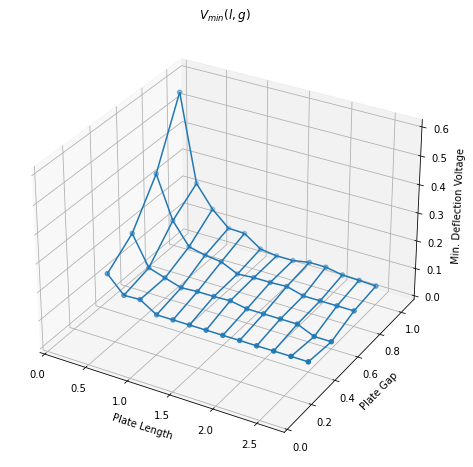

<Figure size 432x288 with 0 Axes>

In [46]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

lgspace_data = np.load(OUT_D + "/minv_grid.npy", allow_pickle=True)

X, Y = np.meshgrid(lgspace_data[0], lgspace_data[1])
V = lgspace_data[2].T

minv_idx = np.unravel_index(V.argmin(), V.shape)
print("Minimum voltage of", round(V[minv_idx], 3), "found at L =", round(X[minv_idx], 3), "and G =", round(Y[minv_idx], 3))

ax.plot_wireframe(X, Y, V)
ax.scatter(X, Y, V)

ax.set_xlim((0, 1.1 * np.max(lgspace_data[0])))
ax.set_ylim((0, 1.1 * np.max(lgspace_data[1])))
ax.set_zlim((0, 1.1 * np.max(lgspace_data[2])))

ax.set_xlabel("Plate Length")
ax.set_ylabel("Plate Gap")
ax.set_zlabel("Min. Deflection Voltage")
ax.set_title("$V_{min}(l, g)$")

plt.show()
plt.savefig(OUT_D + "/minv_grid.png")